# **Import Library**

In [1]:
import numpy as np
import datetime
import pandas as pd

# For fancy visualization
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color_pal = sns.color_palette()


# Important library for deep learning
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,  GRU
import math
from sklearn.metrics import mean_squared_error

# **Load Data**

In [8]:
# Import Dataset
df= pd.read_csv("/content/AMZN_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date']) #import dataset based on your directory
df

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN
...,...,...,...,...,...,...
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN


Our data has 3019 rows × 6 columns, including :
Date, Open, High, Low and Close.

Now, we want to predict the Close Price of Amazon.
So the next step is we drop the other feature except Date and Close.

Additional function for elegan visualization and prediction

In [67]:
def prediction_plot(test,predicted):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set(title="Amazon Stock (Close) Price")
    ax.plot(dates, test, color="r")
    ax.plot(dates, predicted, color="b")
    plt.legend(["Real","Prediction"])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.show()

def rmse_eval(test,predicted):
    rmse = math.sqrt(mean_squared_error(test,predicted))
    print("The root mean squared error is {}.".format(rmse))

In [10]:
# drop some feature
df = df.drop(['Open', 'High', 'Low', 'Volume', 'Name'], axis=1)

# Pre-Processing Data

We can plot the timeseries data of Close Price Amazon Stock between 2006 - 2018.

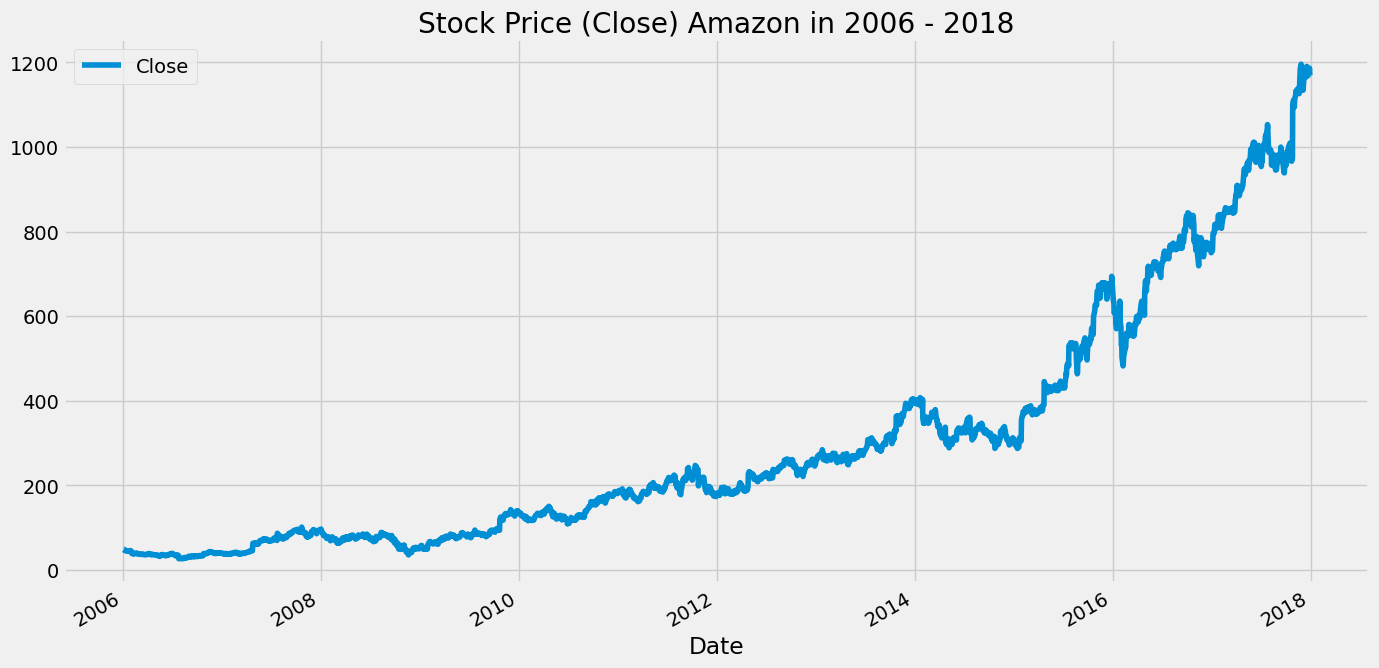

In [11]:
df.plot(style='',
        figsize=(15,8),
        color=color_pal[0],
        title='Stock Price (Close) Amazon in 2006 - 2018')
plt.show()

Based on the plot, show that we have stock price beginning in 2006 to 2018. But we want to know, the trend in every month, and the others.
So we can add the other features like day of week, quarter, month, year, and day, also week.

In [12]:
# Creating Timeseries features
def fitur(df):
  df = df.copy()
  df['Day of Week'] = df.index.dayofweek
  df['Quarter'] = df.index.quarter
  df['Month'] = df.index.month
  df['Year'] = df.index.year
  df['Day'] = df.index.dayofyear
  df['Day of Montrh'] = df.index.day
  df['Week of Year'] = df.index.isocalendar().week
  return(df)

df = fitur(df)

# Quarter

<ipython-input-13-0b5a6766fd09>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Quarter', y='Close', palette='Blues')


Text(0.5, 1.0, 'Stock Price (Close) Amazon in Quarter between 2006-2018')

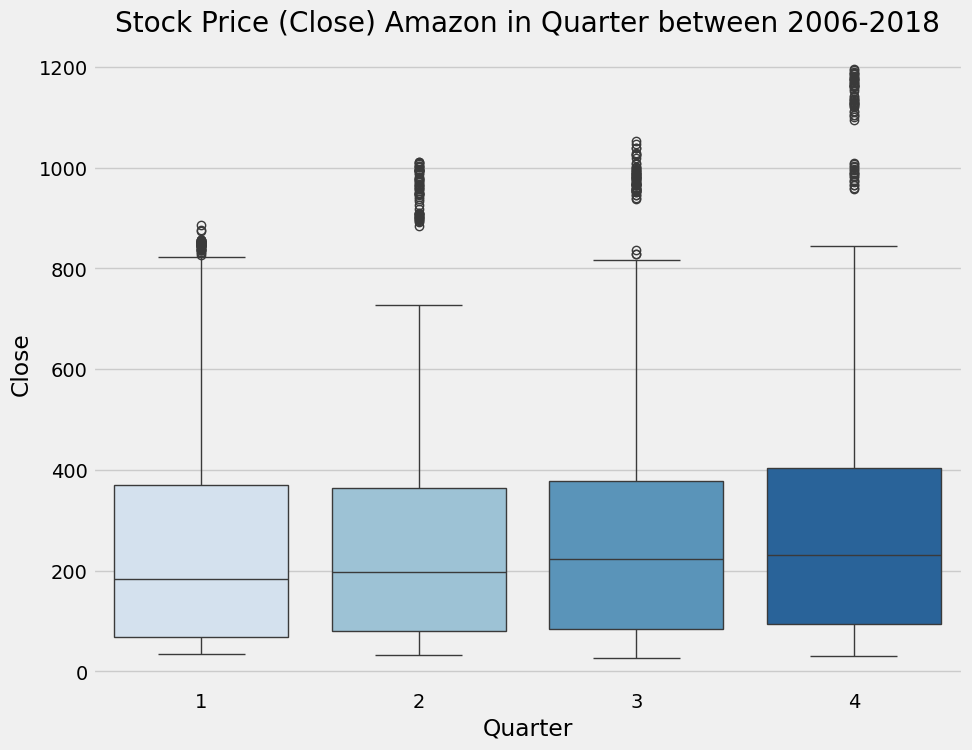

In [13]:
# Visualize Quarter
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Quarter', y='Close', palette='Blues')
ax.set_title('Stock Price (Close) Amazon in Quarter between 2006-2018')

We see, in every Quarter, we found outliers. So this data need to transform it. However, how about the other features ?
Lets plot it.  

# Month

<ipython-input-15-5c2f63de03d1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Month', y='Close', palette='Greens')


Text(0.5, 1.0, 'Stock Price (Close) Amazon in Month between 2006-2018')

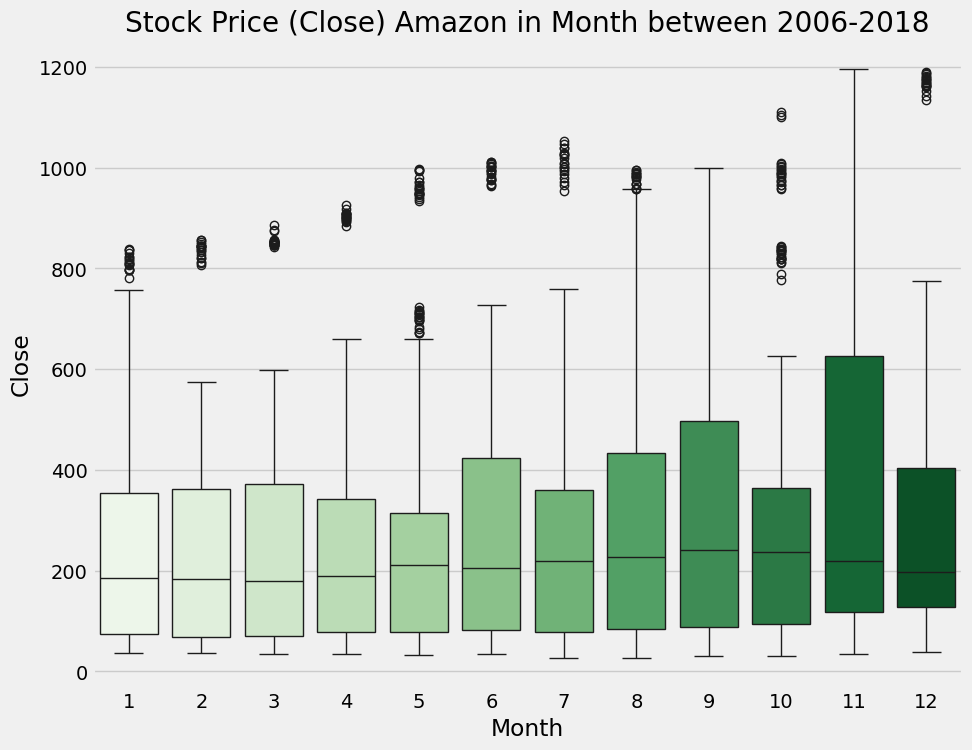

In [15]:
# Month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='Close', palette='Greens')
ax.set_title('Stock Price (Close) Amazon in Month between 2006-2018')

# Year

<ipython-input-16-ac52f6089cad>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Year', y='Close', palette='Reds')


Text(0.5, 1.0, 'Stock Price (Close) Amazon between 2006 - 2018')

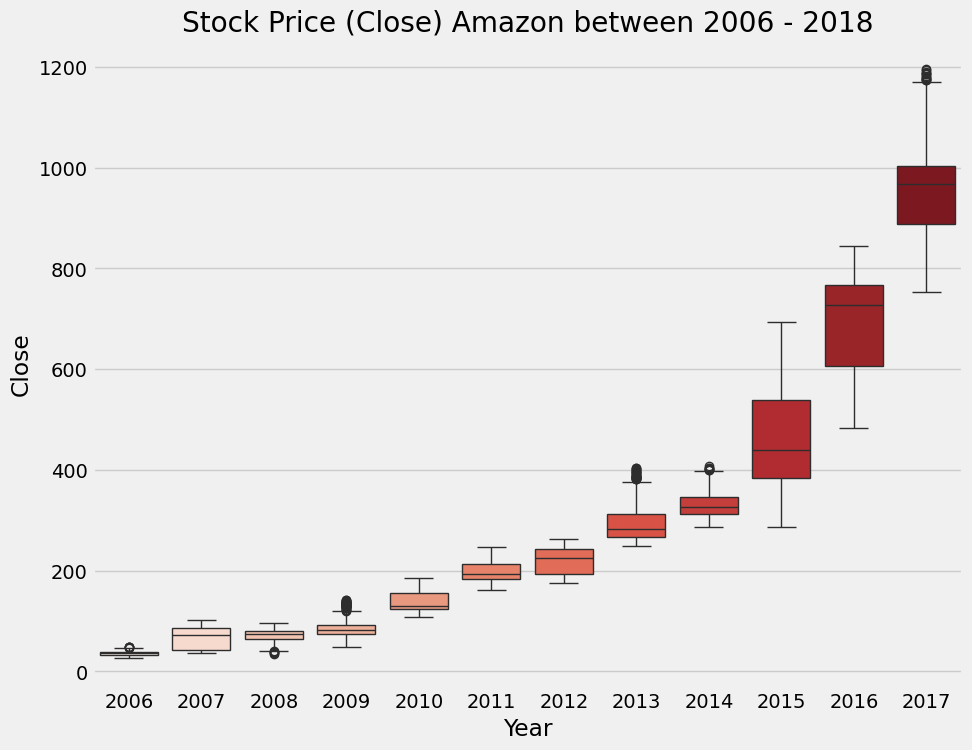

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Year', y='Close', palette='Reds')
ax.set_title('Stock Price (Close) Amazon between 2006 - 2018')

Based on the boxplot, we know that all features we have contain outliers, so we need to fix it with feature engineering.
The technique that we use is min max scaler.

But, before we transform it, we need to split the data we have, into train and test.
The Train data contain before 2016, and the test data over 2016.

# **Training and Test Data**

In [39]:
# Reload Data
# Import Dataset
df= pd.read_csv("/content/AMZN_2006-01-01_to_2018-01-01.csv",
                index_col='Date', parse_dates=['Date'])

df = df.drop(['Open', 'High', 'Low', 'Volume', 'Name'], axis=1)

In [40]:
train = df.loc[df.index < '2016-12-31']
test  = df.loc[df.index > '2016-01-01']

Visualize the training and test data

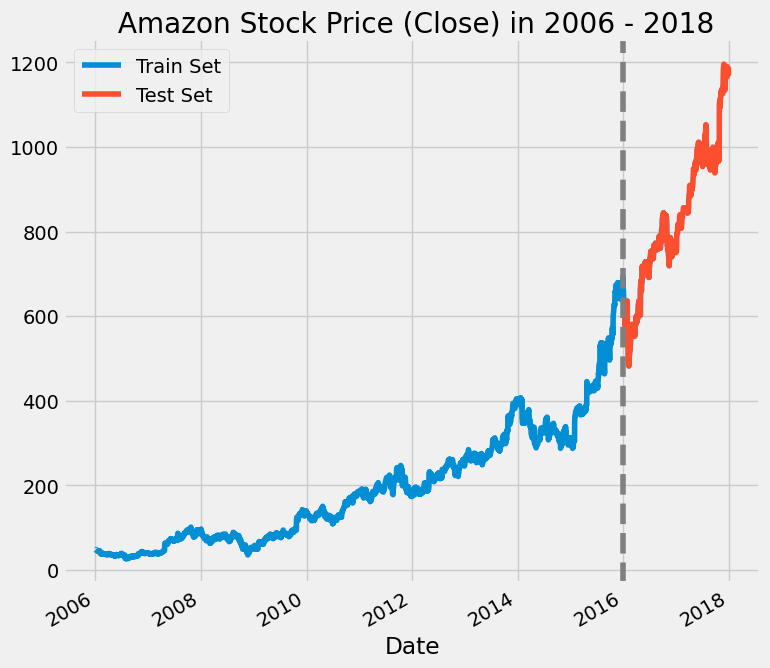

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
train.plot(ax=ax, label = 'Data Train')
test.plot(ax=ax, label = 'Data Test', title = ' Amazon Stock Price (Close) in 2006 - 2018')
ax.axvline('01-01-2016', color = 'grey', ls = '--')
ax.legend(['Train Set', 'Test Set'])
plt.show()

We build again the train and test data.

In [42]:
# Reload Data again
dataset = pd.read_csv("/content/AMZN_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date']) #import dataset based on your directory
training_set = dataset[:'2015'].iloc[:,3].values.reshape(-1,1)
test_set = dataset['2016':].iloc[:,3].values.reshape(-1,1)

In [43]:
training_set.shape

(2516, 1)

the shape tell us that the training set we have is 2516 rows and 1 column, the column is Close (our target feature)

in training set we transform it with minmaxscaler.

In [44]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(2516, 1)

# **DEEP LEARNING**
**Long Short Term Memory (LSTM)**

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to overcome the limitations of traditional RNNs in capturing and learning long-term dependencies in sequential data. RNNs are neural networks that process sequential data by maintaining a hidden state that evolves over time, allowing them to capture information from previous time steps. However, standard RNNs often struggle to effectively learn and retain information over long sequences

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

Source: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968)

The best LSTM explanation on internet: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Refer above link for deeper insights.

Long Short-Term Memory (LSTM) networks consist of several key components, each designed to address the challenges of capturing and learning long-term dependencies in sequential data. The main components of an LSTM unit include:

1.   **Cell State (C_t)**: The cell state represents the long-term memory of the network. It runs straight down the entire chain of the sequence, with only minor linear interactions. The cell state can be updated, modified, or cleared through the information provided by the gates.

2.   **Input Gate (i_t)**: The input gate controls the information that is input to the cell state. It decides which values from the input and previous hidden state should be added to the cell state. The input gate is activated by the sigmoid activation function.
3.   **Forget Gate (f_t)**: The forget gate decides what information should be discarded or kept from the cell state. It takes the previous cell state and the current input as inputs and outputs a forget factor (between 0 and 1) for each component of the cell state. The forget gate is also activated by the sigmoid function.
4.   **Output Gate (o_t)**: The output gate determines the next hidden state based on the cell state. It controls which information from the cell state should be output. The output gate is activated by the sigmoid function.
5.   **Hidden State (h_t)**: The hidden state is the short-term memory of the network. It carries information about the previous time steps and is used for both the next time step's prediction and to influence the cell state. The hidden state is updated based on the input, forget, and output gates.

These components work together to allow LSTMs to selectively store, retrieve, and discard information over time, making them well-suited for learning long-term dependencies in sequential data. The gating mechanisms, in particular, enable LSTMs to mitigate the vanishing gradient problem and capture information over extended sequences.

# Pre-Prediction

Arrange the Array in training data set

In [45]:
# Arrange the data train structure

X_train = []
y_train = []
for i in range(60,training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])

# change it into array
X_train, y_train = np.array(X_train), np.array(y_train)

In [46]:
# Reshaping the X_train for sufficient model
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [47]:
y_train.shape

(2456,)

In [48]:
X_train.shape

(2456, 60, 1)

# **Build LSTM**

Build Architecture LSTM and Fitting model

here, we use the 100 unit of epoch to reduce the error rate

In [49]:
# Sequential Model
model = Sequential()
# first Layer LSTM with Dropout regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# second Layer LSTM  with Dropout regularization
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# third Layer LSTM ketiga with Dropout regularization
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# fourth Layer LSTM
model.add(LSTM(units=100))
model.add(Dropout(0.2))
# Output Layer
model.add(Dense(units=1))
# combined model
model.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to data train
model.fit(X_train,y_train,epochs=100,batch_size=24)

Epoch 1/100
103/103 [==============================] - 25s 169ms/step - loss: 0.0098
Epoch 2/100
103/103 [==============================] - 16s 153ms/step - loss: 0.0039
Epoch 3/100
103/103 [==============================] - 16s 158ms/step - loss: 0.0033
Epoch 4/100
103/103 [==============================] - 15s 150ms/step - loss: 0.0022
Epoch 5/100
103/103 [==============================] - 15s 149ms/step - loss: 0.0017
Epoch 6/100
103/103 [==============================] - 15s 149ms/step - loss: 0.0017
Epoch 7/100
103/103 [==============================] - 16s 158ms/step - loss: 0.0013
Epoch 8/100
103/103 [==============================] - 15s 149ms/step - loss: 0.0012
Epoch 9/100
103/103 [==============================] - 15s 149ms/step - loss: 0.0015
Epoch 10/100
103/103 [==============================] - 16s 153ms/step - loss: 0.0011
Epoch 11/100
103/103 [==============================] - 16s 152ms/step - loss: 0.0012
Epoch 12/100
103/103 [==============================] - 15s 149

In [50]:
# Preparing the df for training and testing dataset
dataset_total = pd.concat((dataset["Close"][:'2015'],dataset["Close"]['2016':]),axis=0)
test = dataset_total[len(dataset_total)-len(test_set) - 60:].values
test = test.reshape(-1,1)


#Transform the inputs
test = sc.transform(test)

In [51]:
test.shape

(563, 1)

In [52]:
# Preparing X_test and the future prediction
# we use 60 days for the next and next predixtion
X_test = []
for i in range(60,test.shape[0]):
    X_test.append(test[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


# Predict the model for the real and test prediction
predict_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predict_stock_price)

16/16 [==============================] - 2s 55ms/step


In [53]:
dates = dataset.index[-1*test.shape[0]+60:]

# Visualize the Prediction

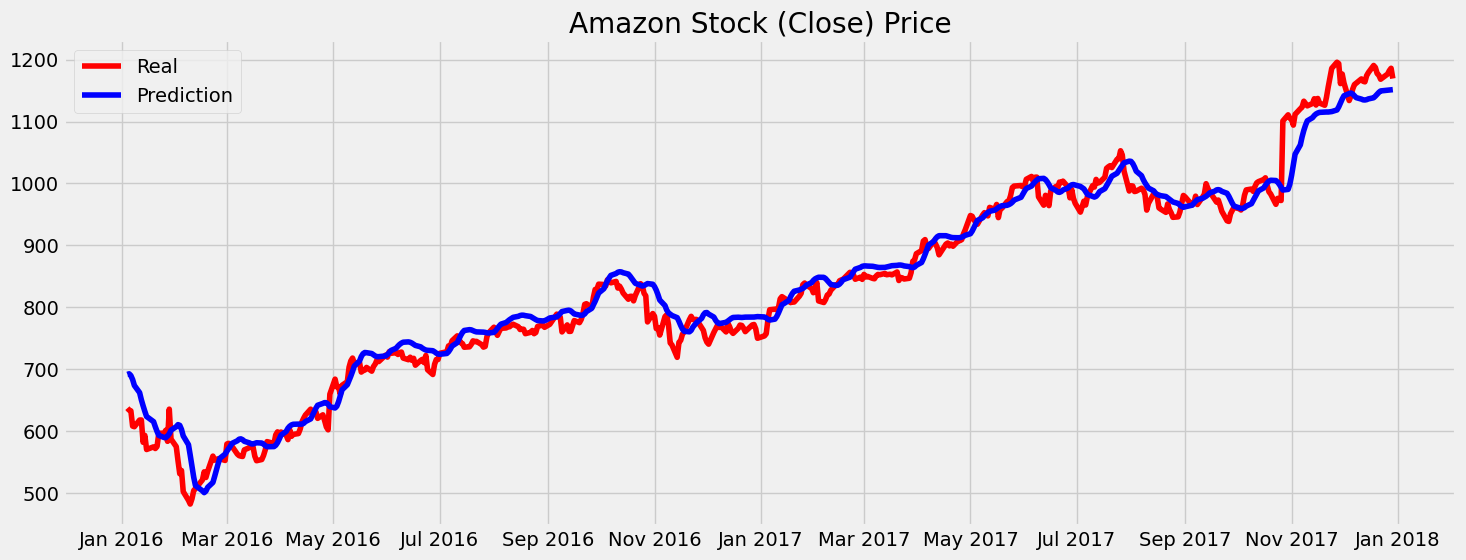

In [68]:
prediction_plot(test_set, predicted_stock_price)

# Evaluation Score

In [55]:
# RMSE score
rmse_eval(test_set, predicted_stock_price)

The root mean squared error is 26.810872070179983.


based on the evaluation of model, we have the RMSE score is 26.81 with layer = 4, epoch = 100 and batch_size = 24.
We can predict the price (closing) of Amazon shares in real time and can detect early if there is an increase or decrease in the price of Amazon shares. This will certainly help in stock trading.